In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import networkx as nx
warnings.filterwarnings('ignore')

## Read data

In [3]:
df_daily = pd.read_csv('Processed data/valid_data_fe.csv')
df_daily.head()

LCLid        Date  kwh_hh  treat  is_weekend  day_of_week_Monday  \
0  MAC000006  2012-01-30   2.162      0           0                   1   
1  MAC000006  2012-01-31   3.906      0           0                   0   
2  MAC000006  2012-02-01   3.587      0           0                   0   
3  MAC000006  2012-02-02   3.416      0           0                   0   
4  MAC000006  2012-02-03   3.739      0           0                   0   

   day_of_week_Saturday  day_of_week_Sunday  day_of_week_Thursday  \
0                     0                   0                     0   
1                     0                   0                     0   
2                     0                   0                     0   
3                     0                   0                     1   
4                     0                   0                     0   

   day_of_week_Tuesday  ...  temp  feelslike  precip  cloudcover    Acorn  \
0                    0  ...   3.0        1.7   0.299        70.1  ACORN-Q   
1                    1  ...   1.7       -0.8   0.298        65.0  ACORN-Q   
2                    0  ...   1.3       -3.6   0.000        35.0  ACORN-Q   
3                    0  ...  -0.2       -4.8   0.000        10.4  ACORN-Q   
4                    0  ...  -0.2       -3.1   0.000        28.5  ACORN-Q   

   Acorn_enc  got_high_signal  got_low_signal  high_signal_intensity  \
0       16.0                0               0                      0   
1       16.0                0               0                      0   
2       16.0                0               0                      0   
3       16.0                0               0                      0   
4       16.0                0               0                      0   

   low_signal_intensity  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  

[5 rows x 34 columns]

## Treatment effects

In [4]:
# !pip3 install dowhy

### OLS with statsmodels - Treatment var: treat_2013


In [5]:
import statsmodels.api as sm

In [167]:
X = df_daily.drop(columns=['LCLid', 'Date', 'kwh_hh', 'Acorn', 'got_high_signal', 'got_low_signal', 'high_signal_intensity', 'low_signal_intensity', 'is_weekend'])
X = X.drop([col for col in X.columns if col.startswith('month')], axis=1) # Drop months
X = sm.add_constant(X)
y = df_daily['kwh_hh']

In [168]:
model = sm.OLS(y, X)
results = model.fit(cov_type='HC1')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 kwh_hh   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1242.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        09:45:51   Log-Likelihood:            -1.3492e+06
No. Observations:              376769   AIC:                         2.699e+06
Df Residuals:                  376754   BIC:                         2.699e+06
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    14.06

### OLS with statsmodels - Treatment vars: got signal and intensities

In [169]:
X = df_daily.drop(columns=['LCLid', 'Date', 'kwh_hh', 'Acorn', 'high_signal_intensity', 'low_signal_intensity', 'is_weekend'])
X = X.drop([col for col in X.columns if col.startswith('month')], axis=1) # Drop months
# X['treat_got_high_signal'] = X['got_high_signal'] * X['treat_2013']
# X['treat_got_low_signal'] = X['got_low_signal'] * X['treat_2013']
# X = X.drop(columns = ['got_high_signal', 'got_low_signal'])
X = sm.add_constant(X)
y = df_daily['kwh_hh']

In [170]:
model = sm.OLS(y, X)
results = model.fit(cov_type='HC1')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 kwh_hh   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1089.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        09:46:28   Log-Likelihood:            -1.3492e+06
No. Observations:              376769   AIC:                         2.699e+06
Df Residuals:                  376752   BIC:                         2.699e+06
Df Model:                          16                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    14.06

### DoWhy causal model

In [12]:
from dowhy import CausalModel
import dowhy
import dowhy.datasets

In [287]:
# data = dowhy.datasets.linear_dataset(beta=10,
#         num_common_causes=5,
#         num_instruments = 2,
#         num_effect_modifiers=1,
#         num_samples=5000,
#         treatment_is_binary=True,
#         stddev_treatment_noise=10,
#         num_discrete_common_causes=1)
# df = data["df"]

In [13]:
df_daily.columns

Index(['LCLid', 'Date', 'kwh_hh', 'treat', 'is_weekend', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'year_2013', 'treat_2013', 'temp',
       'feelslike', 'precip', 'cloudcover', 'Acorn', 'Acorn_enc',
       'got_high_signal', 'got_low_signal', 'high_signal_intensity',
       'low_signal_intensity'],
      dtype='object')

In [174]:
causes = ['day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'temp',
       'feelslike', 'precip', 'cloudcover'
        ,'Acorn_enc'   
    #    ,'year_2013'
    #    ,'is_weekend'
        ]

In [180]:
# Without graph
model= CausalModel(
        data=df_daily,
        treatment='treat_2013',
        # common_causes = ['treat', 'Acorn_enc'],
        # common_causes = 'Acorn_enc',
        common_causes = 'treat',
        outcome="kwh_hh",
        effect_modifiers=causes)


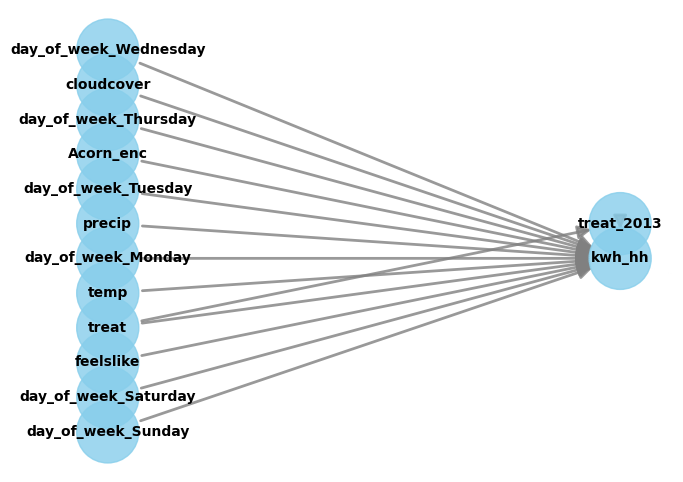

In [181]:
model.view_model()

In [182]:
# help(CausalModel)

In [183]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                       
────────────(E[kwh_hh|treat])
d[treat₂₀₁₃]                 
Estimand assumption 1, Unconfoundedness: If U→{treat_2013} and U→kwh_hh then P(kwh_hh|treat_2013,treat,U) = P(kwh_hh|treat_2013,treat)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [184]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
# print(causal_estimate)

In [185]:
causal_estimate.value

#### Refute estimate

In [29]:
# Adding a random common cause variable
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause", show_progress_bar=True)
print(res_random)

Refuting Estimates: 100%|██████████| 100/100 [03:17<00:00,  1.98s/it]

Refute: Add a random common cause
Estimated effect:-0.2459903635366647
New effect:-0.2459755604148635
p value:0.98



In [30]:
# Replacing treatment with a random (placebo) variable
res_placebo=model.refute_estimate(identified_estimand, causal_estimate,
        method_name="placebo_treatment_refuter", show_progress_bar=True, placebo_type="permute")
print(res_placebo)

Refuting Estimates:  98%|█████████▊| 98/100 [03:30<00:04,  2.28s/it]

KeyboardInterrupt: 

In [369]:
# Removing random subset of the data
res_subset=model.refute_estimate(identified_estimand, causal_estimate,
        method_name="data_subset_refuter", show_progress_bar=True, subset_fraction=0.9)
print(res_subset)


Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]/Users/alvarocorralescano/opt/anaconda3/envs/idealista/lib/python3.11/site-packages/dowhy/causal_estimator.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/Users/alvarocorralescano/opt/anaconda3/envs/idealista/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/alvarocorralescano/opt/anaconda3/envs/idealista/lib/python3.11/site-packages/dowhy/causal_estimators/regression_es

Refute: Use a subset of data
Estimated effect:-0.24599036353669845
New effect:-0.246534192077676
p value:1.0



### Alternative graph model - average effect of receiving low and high signals and their intensity

In [28]:
df_daily.columns

Index(['LCLid', 'Date', 'kwh_hh', 'treat', 'is_weekend', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'year_2013', 'treat_2013', 'temp',
       'feelslike', 'precip', 'cloudcover', 'Acorn', 'Acorn_enc',
       'got_high_signal', 'got_low_signal', 'high_signal_intensity',
       'low_signal_intensity'],
      dtype='object')

In [191]:
# Initialize directed graph
G = nx.DiGraph()

# List of causes
causes = ['day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'temp',
       'feelslike', 'precip', 'cloudcover'] 
       
# Add edges from each cause to 'kwh_hh'
for cause in causes:
    G.add_edge(cause, 'kwh_hh')

# Add the paths described in the question
# Path 1: treat [> got_high_signal] > high_signal_intensity > kwh_hh
# G.add_edges_from([
#     ('treat_2013', 'got_high_signal'),
#     ('got_high_signal', 'kwh_hh')
# ])

# G.add_edges_from([
#     ('treat_2013', 'got_high_signal'),
#     ('got_high_signal', 'kwh_hh')
# ])

# Path 2: treat [> got_low_signal] > low_signal_intensity > kwh_hh
# G.add_edges_from([
#     ('treat_2013', 'got_low_signal'),
#     ('got_low_signal', 'kwh_hh')
# ])

# Path 3: acorn_enc > treat > kwh_hh
# G.add_edges_from([
#     ('Acorn_enc', 'treat'),
#     ('treat', 'kwh_hh')
# ])

# Path 4: acorn_enc > kwh_hh
G.add_edge('Acorn_enc', 'kwh_hh')

# Path 5: treatment > 2013 > kwh_hh
G.add_edges_from([
    ('treat', 'year_2013'),
    ('year_2013', 'kwh_hh')
])

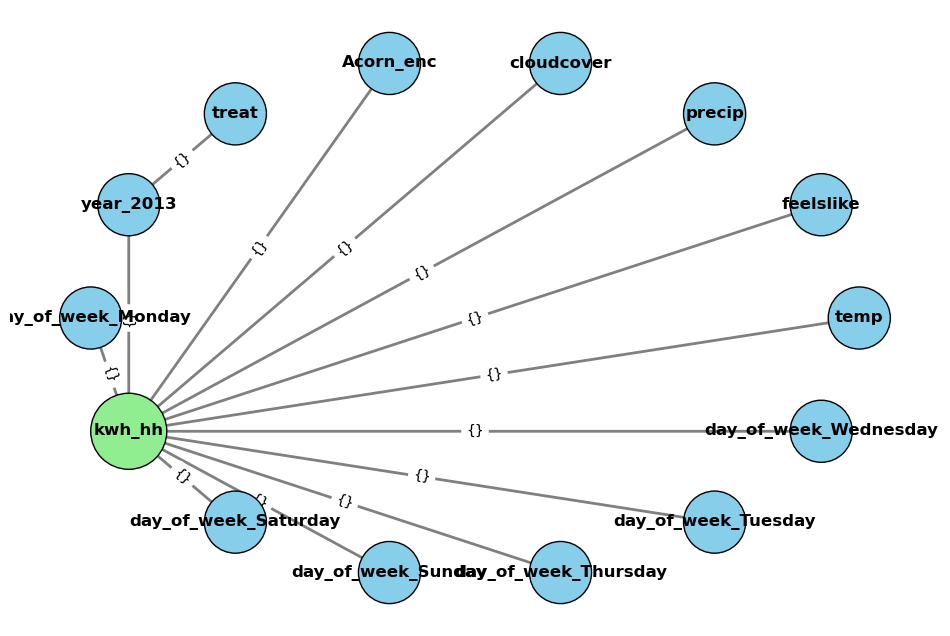

In [192]:
# Draw the graph
plt.figure(figsize=(12, 8))

# Use shell layout for a more circular, cleaner arrangement
pos = nx.shell_layout(G)  

# Draw nodes with a color gradient and different sizes based on their degree
node_sizes = [3000 if node == 'kwh_hh' else 2000 for node in G.nodes()]
node_colors = ['lightgreen' if node == 'kwh_hh' else 'skyblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')

# Draw edges with arrows and custom width/color
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray', width=2)

# Add labels to the nodes
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', font_weight='bold')

# Add edge labels (optional: if you want to label the edges)
# edge_labels = {('treat', 'got_high_signal'): 'High Path',
#                ('treat', 'got_low_signal'): 'Low Path',
#                ('Acorn_enc', 'treat'): 'Treat Path'}
nx.draw_networkx_edge_labels(G, pos, font_size=10)

# Remove axis for a cleaner look
plt.axis('off')

# Show the graph
plt.show()


In [193]:
model2 = CausalModel(
   data=df_daily, # some pandas dataframe
   treatment=['treat'],
   common_causes = ['Accorn_enc'],
   effect_modifiers=causes,
   outcome="kwh_hh",
   graph="\n".join(nx.generate_gml(G))
)

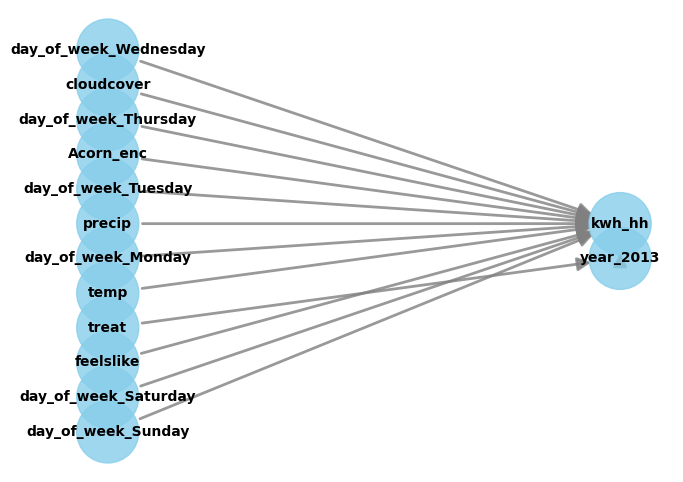

In [194]:
model2.view_model()

In [195]:
identified_estimand2 = model2.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand2)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d              
────────(E[kwhₕₕ])
d[treat]          
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→kwh_hh then P(kwh_hh|treat,,U) = P(kwh_hh|treat,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡     d                d                ⎤
E⎢───────────(kwhₕₕ)⋅────────([year₂₀₁₃])⎥
 ⎣d[year₂₀₁₃]        d[treat]            ⎦
Estimand assumption 1, Full-mediation: year_2013 intercepts (blocks) all directed paths from treat to k,w,h,_,h,h.
Estimand assumption 2, First-stage-unconfoundedness: If U→{treat} and U→{year_2013} then P(year_2013|treat,U) = P(year_2013|treat)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{year_2013} and U→kwh_hh then P(kwh_hh|year_2013, treat, U) = P(kwh_hh|year_2013, treat)



In [196]:
causal_estimate2 = model2.estimate_effect(identified_estimand2,
        method_name="backdoor.linear_regression")
print('Causal estimate value:', causal_estimate2.value)

Causal estimate value: -0.7428822794034282


How do we interpret this number? it's the average of the effect of a low signal intensity and a high signal intensity, which probably have opposite signs.

In [65]:
# help(model.estimate_effect)

#### Refute estimate

In [68]:
# Adding a random common cause variable
res_random=model2.refute_estimate(identified_estimand2, causal_estimate2, method_name="random_common_cause", show_progress_bar=True)
print(res_random)

Refuting Estimates: 100%|██████████| 100/100 [04:43<00:00,  2.83s/it]

Refute: Add a random common cause
Estimated effect:0.06968556259982428
New effect:0.0697377811157582
p value:0.74



In [69]:
# # Replacing treatment with a random (placebo) variable
# res_placebo=model2.refute_estimate(identified_estimand2, causal_estimate2,
#         method_name="placebo_treatment_refuter", show_progress_bar=True, placebo_type="permute")
# print(res_placebo)

In [70]:
# Removing random subset of the data
res_subset=model2.refute_estimate(identified_estimand2, causal_estimate2,
        method_name="data_subset_refuter", show_progress_bar=True, subset_fraction=0.9)
print(res_subset)

KeyboardInterrupt: 

### Alternative graph model - separate models for each intensity

In [217]:
# Initialize directed graph
G = nx.DiGraph()

# List of causes
causes = ['day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'temp',
       'feelslike', 'precip', 'cloudcover'] 
       
# Add edges from each cause to 'kwh_hh'
for cause in causes:
    G.add_edge(cause, 'kwh_hh')

# Add the paths described in the question
# Path 1: treat [> got_high_signal] > high_signal_intensity > kwh_hh
G.add_edges_from([
    ('treat', 'year_2013'),
    ('year_2013', 'got_high_signal'),
    ('got_high_signal', 'kwh_hh')
])

# Path 2: treat [> got_low_signal] > low_signal_intensity > kwh_hh
G.add_edges_from([
    ('treat', 'year_2013'),
    ('year_2013', 'got_low_signal'),
    ('got_low_signal', 'kwh_hh')
])

# Path 3: acorn_enc > treat > kwh_hh
# G.add_edges_from([
#     ('Acorn_enc', 'treat'),
#     ('treat', 'kwh_hh')
# ])

# Path 4: acorn_enc > kwh_hh
G.add_edge('Acorn_enc', 'kwh_hh')

# Path 5: treatment > 2013 > kwh_hh
G.add_edges_from([
    ('treat', 'year_2013'),
    ('year_2013', 'kwh_hh')
])

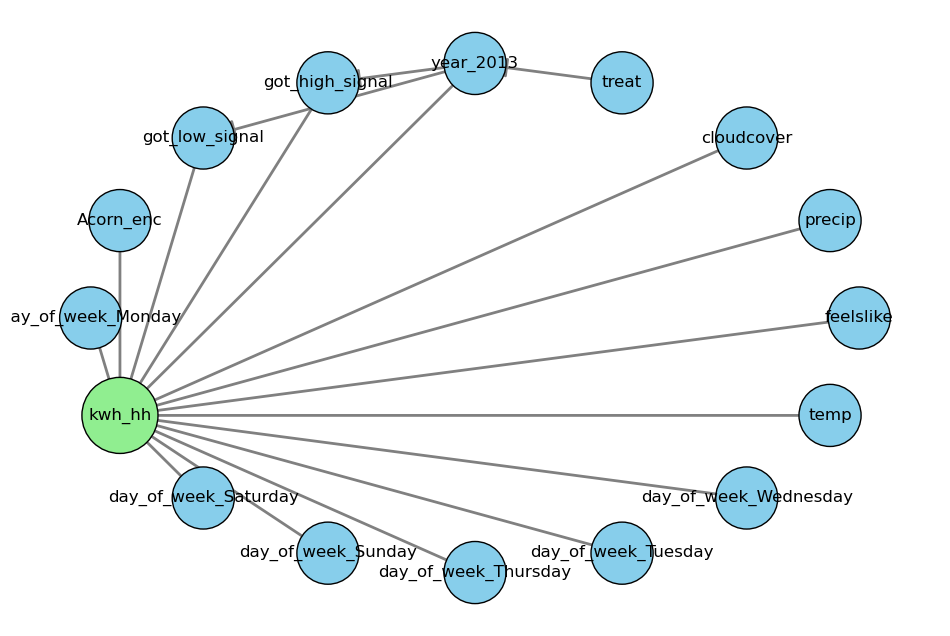

In [218]:
import matplotlib.pyplot as plt
import networkx as nx

# Draw the graph
plt.figure(figsize=(12, 8))

# Use shell layout for a more circular, cleaner arrangement
pos = nx.shell_layout(G)  

# Draw nodes with a color gradient and different sizes based on their degree
node_sizes = [3000 if node == 'kwh_hh' else 2000 for node in G.nodes()]
node_colors = ['lightgreen' if node == 'kwh_hh' else 'skyblue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')

# Draw edges with arrows and custom width/color
# Increase arrowsize for better visibility
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=30, edge_color='gray', width=2)

# Add labels to the nodes
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

# Comment out or remove the edge label drawing function since no labels are provided
# nx.draw_networkx_edge_labels(G, pos, font_size=10)

# Remove axis for a cleaner look
plt.axis('off')

# Show the graph
plt.show()



In [219]:
# Low intensity model
# Define model
model_low = CausalModel(
   data=df_daily, # some pandas dataframe
   treatment=['got_low_signal'],
#    common_causes = 'Acorn_enc',
   effect_modifiers=causes.append('Acorn_enc'),
   outcome="kwh_hh",
   graph="\n".join(nx.generate_gml(G))
)

# Identify estimand
identified_estimand_low = model_low.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand_low)

# Quantify causal estimate
causal_estimate_low = model_low.estimate_effect(
    identified_estimand_low,
    method_name="backdoor.linear_regression",
    # confidence_intervals = True
    )
print('Causal estimate value:', round(causal_estimate_low.value, 4))
# print('Causal estimate CI:', causal_estimate_low.get_confidence_intervals())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                             
─────────────────(E[kwh_hh|year_2013])
d[got_low_signal]                     
Estimand assumption 1, Unconfoundedness: If U→{got_low_signal} and U→kwh_hh then P(kwh_hh|got_low_signal,year_2013,U) = P(kwh_hh|got_low_signal,year_2013)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Causal estimate value: -0.7097


In [220]:
# High intensity model
# Define model
model_high = CausalModel(
   data=df_daily, # some pandas dataframe
   treatment=['got_high_signal'],
#    common_causes = 'Acorn_enc',
   effect_modifiers=causes.append('Acorn_enc'),
   outcome="kwh_hh",
   graph="\n".join(nx.generate_gml(G))
)

# Identify estimand
identified_estimand_high = model_high.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand_high)

# Quantify causal estimate
causal_estimate_high = model_high.estimate_effect(
    identified_estimand_high,
    method_name="backdoor.linear_regression",
    # confidence_intervals = True
    )
print('Causal estimate value:', round(causal_estimate_high.value, 4))
# print('Causal estimate value:', causal_estimate_high.get_confidence_intervals())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                              
──────────────────(E[kwh_hh|year_2013])
d[got_high_signal]                     
Estimand assumption 1, Unconfoundedness: If U→{got_high_signal} and U→kwh_hh then P(kwh_hh|got_high_signal,year_2013,U) = P(kwh_hh|got_high_signal,year_2013)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Causal estimate value: -1.0962


In [106]:
# causal_estimate_high.get_confidence_intervals()

In [125]:
causal_estimate_high.conditional_estimates.index.names

FrozenList(['__categorical__day_of_week_Sunday', '__categorical__is_weekend', '__categorical__day_of_week_Saturday', '__categorical__feelslike', '__categorical__temp', '__categorical__got_low_signal', '__categorical__day_of_week_Monday', '__categorical__day_of_week_Tuesday', '__categorical__day_of_week_Thursday', '__categorical__day_of_week_Wednesday', '__categorical__cloudcover', '__categorical__precip'])

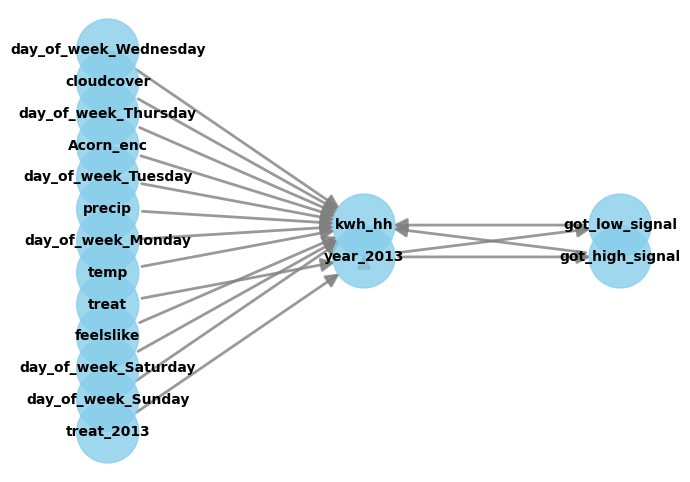

In [212]:
model_high.view_model()